In [1]:
!pip install pandas seaborn google-cloud-aiplatform tdqm
!gcloud auth application-default login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login&state=vgHhmkdASbFBBCaWLZrTFmdopgD38e&access_type=offline&code_challenge=cxtVZw0ij-fb7la5uce62yKWxoPHz9ZOawvi5QhKtL8&code_challenge_method=S256


Credentials saved to file: [/Users/alistairkeiller/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).
Cannot find a quota project to add to ADC. You might receive a "quota exceeded" or "API not enabled" error. Run $ gcloud auth application-default set-quota-project to add a quota project.


In [1]:
import pandas as pd
import glob
import csv
import re
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import google.generativeai as genai
import os
from tqdm import tqdm

In [2]:
import base64
import vertexai
from vertexai.generative_models import GenerativeModel, Part, FinishReason
import vertexai.preview.generative_models as generative_models

vertexai.init(project="yolo-410704", location="us-central1")
gemini_pro = GenerativeModel("gemini-pro")
gemini_pro_long = GenerativeModel("gemini-1.5-pro-preview-0409")

In [3]:
dfs = []

def read_file(file):
    try:
        return open(directory+file+".txt", "r").read()
    except:
        return None

for info_file in glob.glob("RusLit/**/info.csv", recursive=True):
    try:
        directory = info_file[:-8]
        info = pd.read_csv(info_file)
        info["author"] = directory.split("/")[2]
        info["type"] = directory.split("/")[1]
        info["text"] = info["name"].map(read_file)
        dfs.append(info)
    except:
        pass

df = pd.concat(dfs, ignore_index=True).dropna()
df["year"] = df["year"].astype(str).map(lambda x: x.split("-")[0].split(".")[0]).astype(int)

In [4]:
def get_genres(text):
    try:
        return gemini_pro.generate_content(text+"Respond with a comma seperated list of the single-word genres to describe the above text: ").candidates[0].content.parts[0].text
    except:
        try:
            return gemini_pro_long.generate_content(text+"Respond with a comma seperated list of the single-word genres to describe the above text: ").candidates[0].content.parts[0].text
        except:
            return None

try:
    df = pd.read_csv("test.csv")
except:
    df['genres'] = [get_genres(text) for text in tqdm(df['text'], desc="Generating genres")]
    df.to_csv("test.csv")

In [5]:
df = df.dropna()
df["genres"] = df["genres"].map(lambda x: x.strip().lower().split(", "))

In [6]:
df_explode = df.explode('genres')
df_explode = df_explode[df_explode['genres'] != ""]
genre_trends = df_explode.groupby(['year', 'genres']).size().unstack(fill_value=0)
filtered_genre_trends = genre_trends[genre_trends.sum().sort_values()[-10:].index]
percentage_filtered_genre_trends = filtered_genre_trends.divide(filtered_genre_trends.sum(axis=1), axis=0) * 100
percentage_filtered_genre_trends.dropna()
percentage_filtered_genre_trends = percentage_filtered_genre_trends.reset_index()
melted_percentage_filtered_genre_trends = percentage_filtered_genre_trends.melt(id_vars='year', var_name='genre', value_name='popularity')

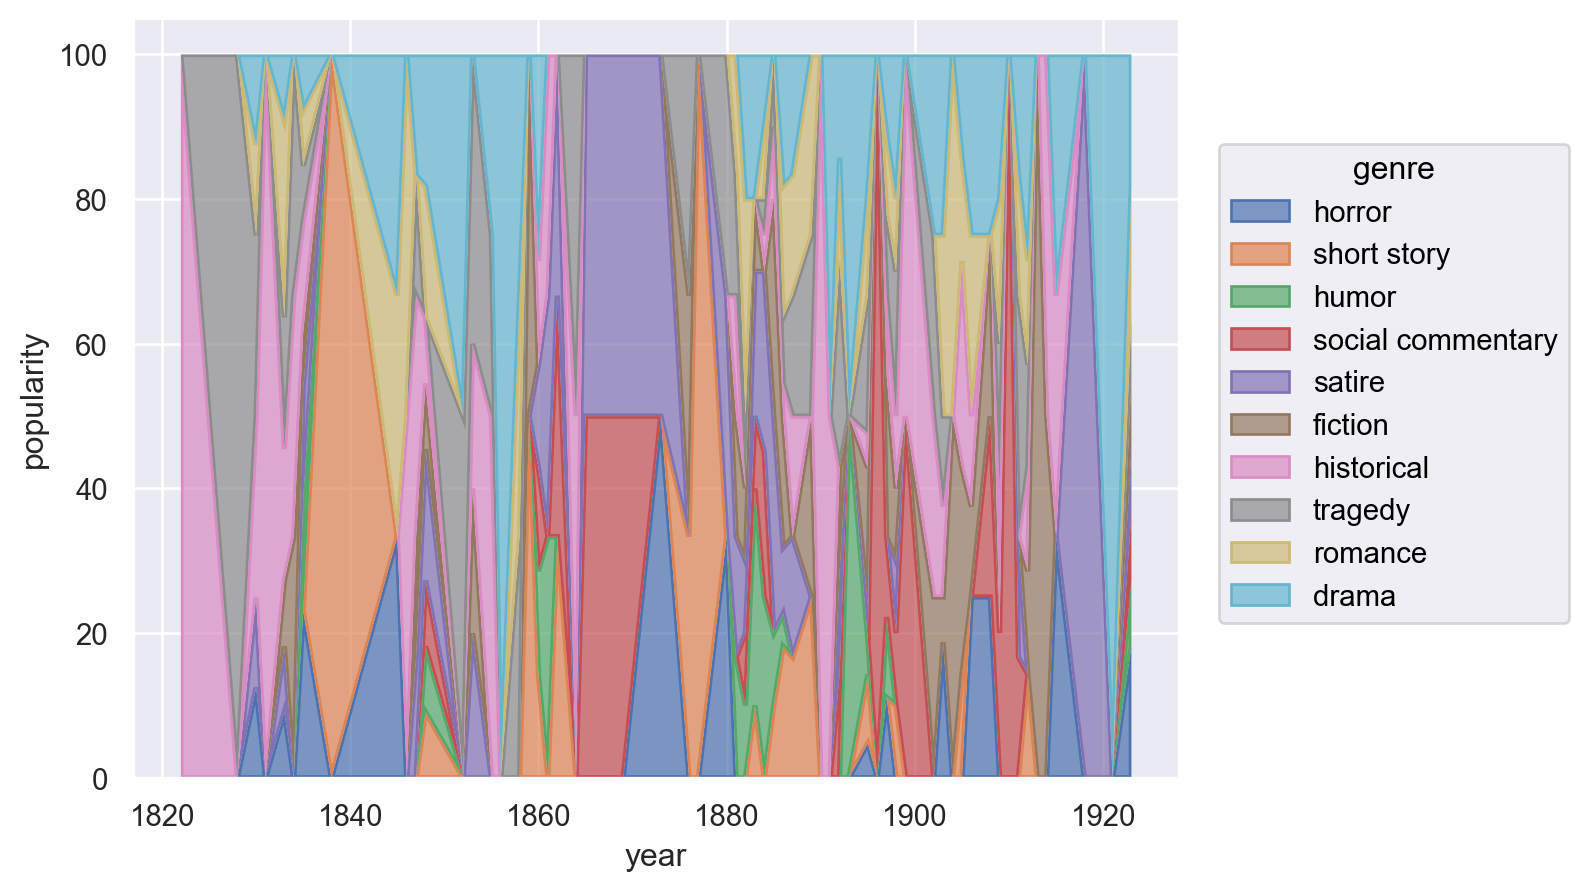

In [7]:
so.Plot(melted_percentage_filtered_genre_trends, "year", "popularity", color="genre").add(so.Area(alpha=.7), so.Stack())

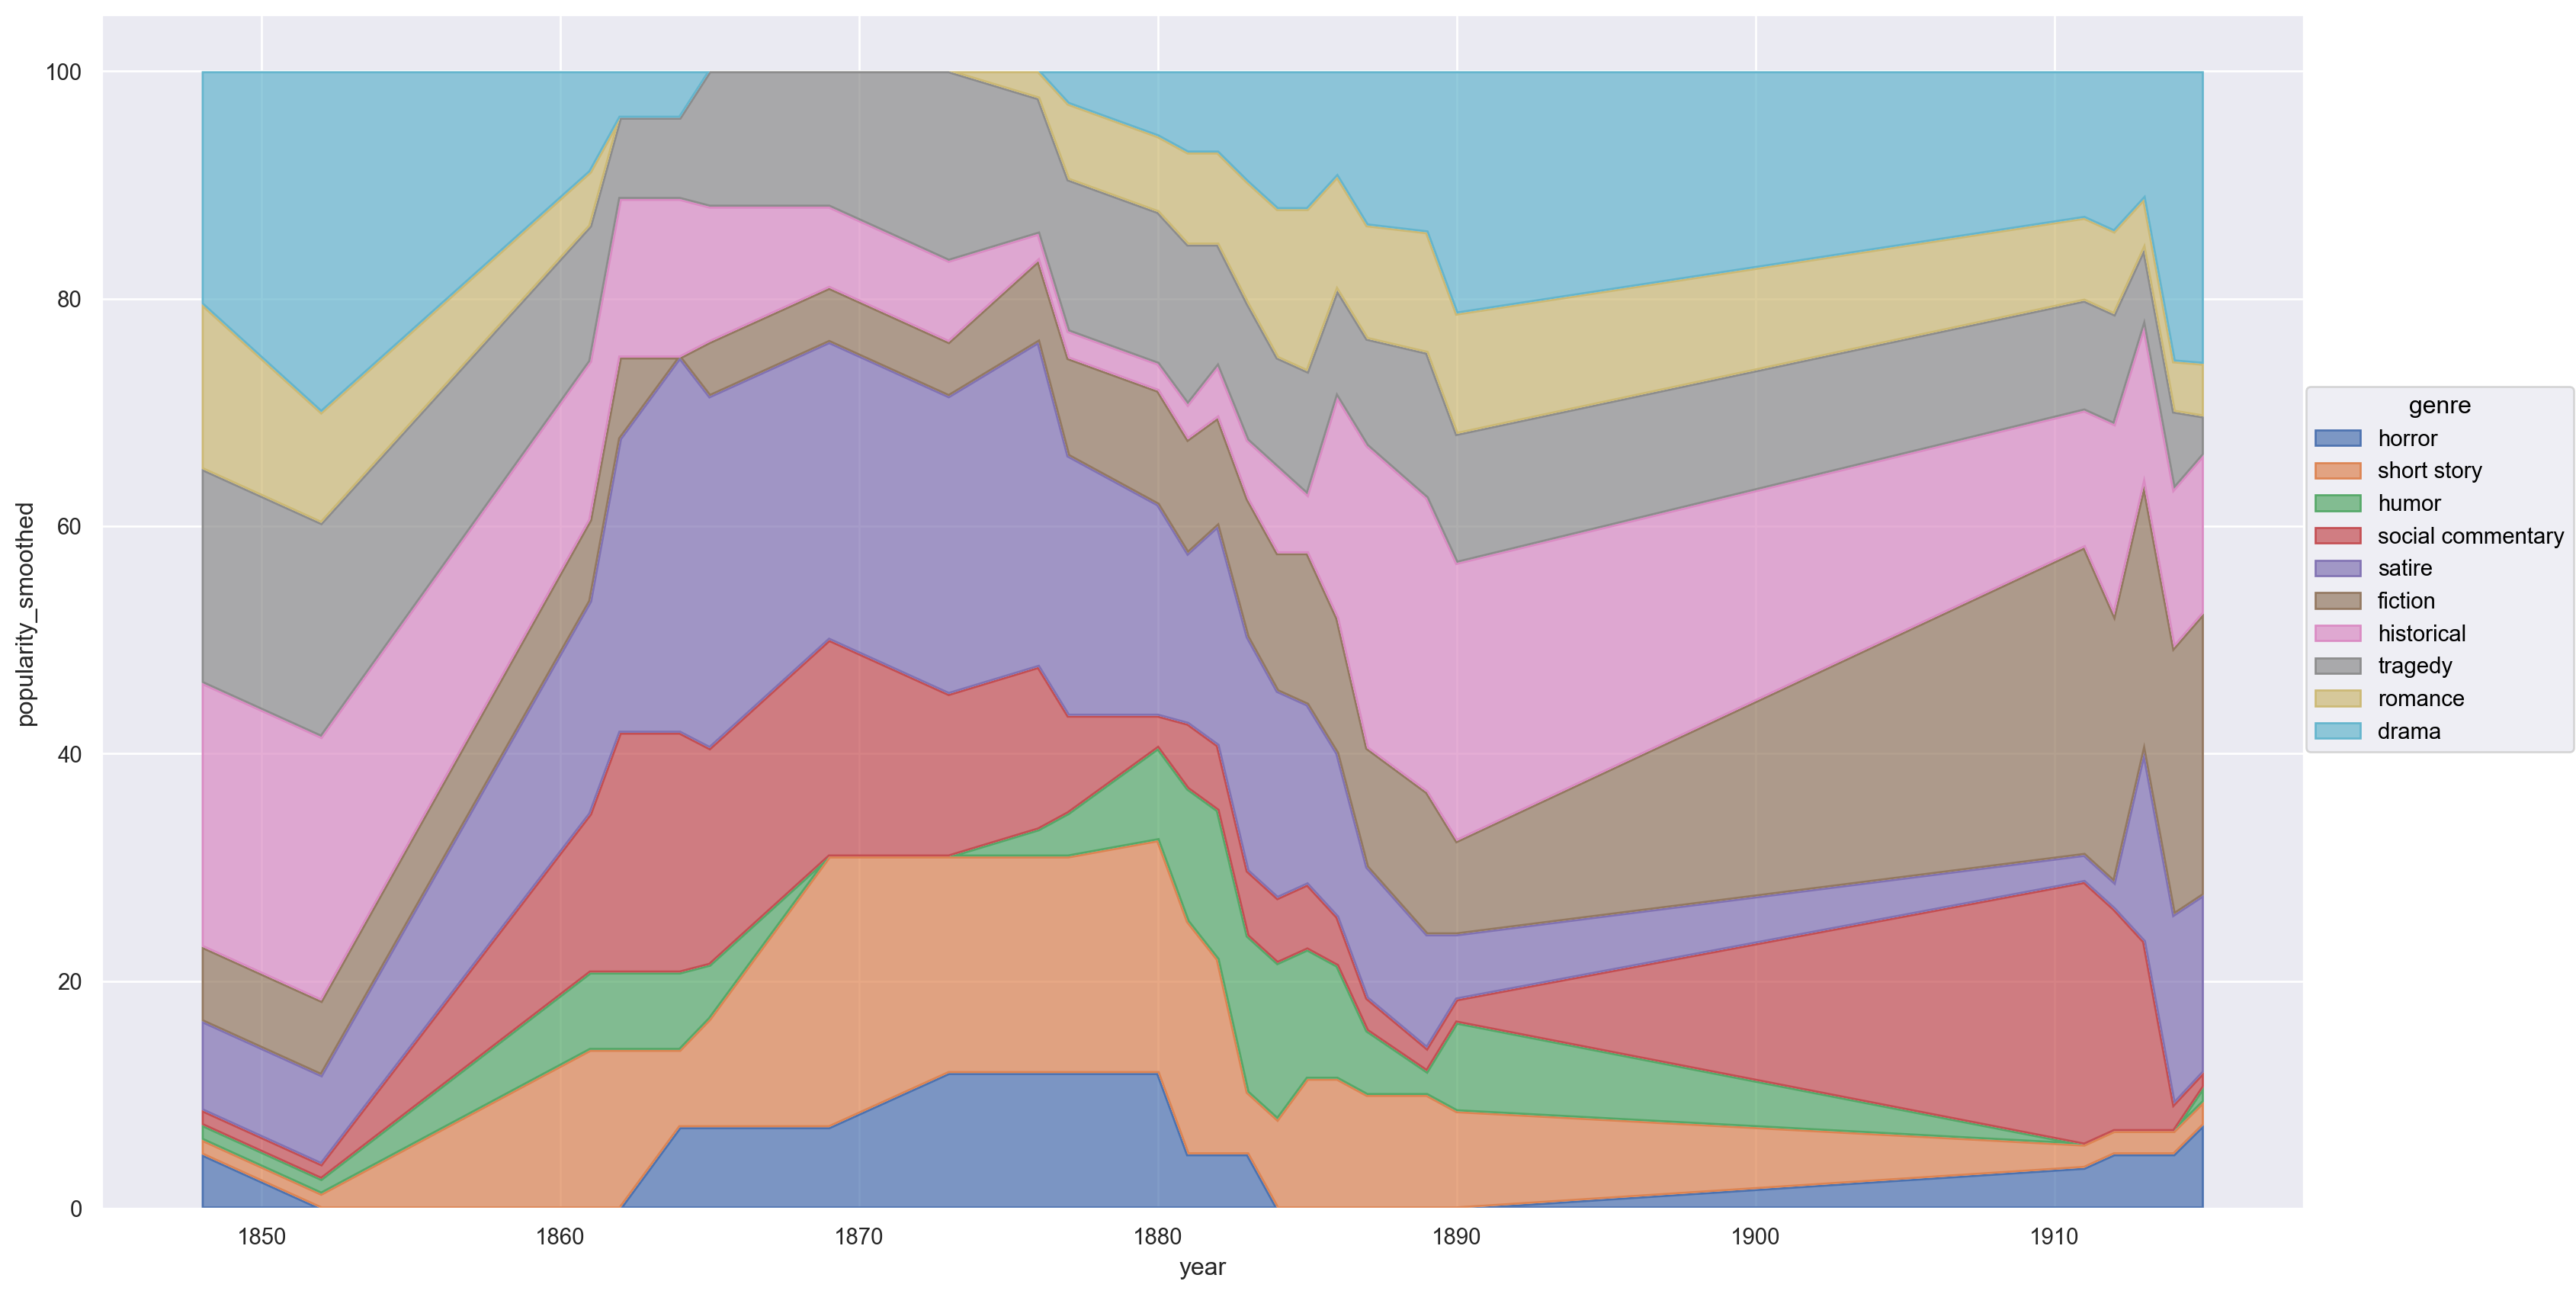

In [8]:
window_size = 7

melted_percentage_filtered_genre_trends['popularity_smoothed'] = (
    melted_percentage_filtered_genre_trends.groupby('genre')['popularity']
    .transform(lambda x: x.rolling(window=window_size, center=True).mean())
)

so.Plot(melted_percentage_filtered_genre_trends, "year", "popularity_smoothed", color="genre").add(so.Area(alpha=.7), so.Stack()).layout(size=(16, 9)).save("test.png", bbox_inches='tight')

In [10]:
melted_percentage_filtered_genre_trends.to_csv("output.csv")

In [16]:
gemini_pro_long.generate_content("\"The play portrays the visit of an elderly professor and his glamorous, much younger second wife, Yelena, to the rural estate that supports their urban lifestyle. Two friends—Vanya, brother of the professor's late first wife, who has long managed the estate, and Astrov, the local doctor—both fall under Yelena's spell while bemoaning the ennui of their provincial existence. Sonya, the professor's daughter by his first wife, who has worked with Vanya to keep the estate going, suffers from her unrequited feelings for Astrov. Matters are brought to a crisis when the professor announces his intention to sell the estate, Vanya and Sonya's home, with a view to investing the proceeds to achieve a higher income for himself and his wife.\"\nRepeat each sentance with a catigorization after: horror short story humor social commentary satire fiction historical tragedy romance drama").candidates[0].content.parts[0].text

'*   "The play portrays the visit of an elderly professor and his glamorous, much younger second wife, Yelena, to the rural estate that supports their urban lifestyle." - **drama** \n*   "Two friends—Vanya, brother of the professor\'s late first wife, who has long managed the estate, and Astrov, the local doctor—both fall under Yelena\'s spell while bemoaning the ennui of their provincial existence." - **drama**\n*   "Sonya, the professor\'s daughter by his first wife, who has worked with Vanya to keep the estate going, suffers from her unrequited feelings for Astrov." - **romance**\n*   "Matters are brought to a crisis when the professor announces his intention to sell the estate, Vanya and Sonya\'s home, with a view to investing the proceeds to achieve a higher income for himself and his wife." - **drama** \n'

In [20]:
gemini_pro_long.generate_content("\"The play portrays the visit of an elderly professor and his glamorous, much younger second wife, Yelena, to the rural estate that supports their urban lifestyle. Two friends—Vanya, brother of the professor's late first wife, who has long managed the estate, and Astrov, the local doctor—both fall under Yelena's spell while bemoaning the ennui of their provincial existence. Sonya, the professor's daughter by his first wife, who has worked with Vanya to keep the estate going, suffers from her unrequited feelings for Astrov. Matters are brought to a crisis when the professor announces his intention to sell the estate, Vanya and Sonya's home, with a view to investing the proceeds to achieve a higher income for himself and his wife.\"\nRewrite the abstract like Uncle Vanya was a political commentary satire of Russia in 1870:").candidates[0].content.parts[0].text

"## Uncle Vanya: A Tsarist Russia Tragicomedy\n\nThe play unveils the festering decay at the heart of Tsarist Russia, symbolized by the decaying rural estate of an aging, out-of-touch Professor. This estate, much like the Russian Empire, is kept afloat by the tireless labor of Sonya, representing the overburdened peasantry, and Vanya, the disillusioned intelligentsia, both trapped in service to a system that offers them no future. \n\nThe arrival of the Professor and his young wife Yelena, a figure of captivating yet empty beauty, exposes the stark inequalities and moral bankruptcy of the ruling class. Yelena embodies the frivolous aristocracy, concerned only with appearances and immediate pleasure, oblivious to the consequences of their actions on the struggling masses. \n\nAstrov, the local doctor, represents the frustrated intellectual, aware of the societal ills but powerless to enact change. Both he and Vanya are captivated by Yelena, highlighting the escapist fantasies that distr